
The dataset columns are as follows

* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie (in millions)
* Promo: How much money was spent promoting the movie (in millions)
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop


# Data loading

Load the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final/data.csv')


Mounted at /content/drive


In [33]:
median_stars = df['Stars'].median()
df.loc[df['Stars'] > 5, 'Stars'] = median_stars

median_runtime = df['Runtime'].median()
df.loc[df['Runtime'] == 0, 'Runtime'] = median_runtime

df['Budget'] = df['Budget'].apply(lambda x: x if x < 1000 else x / 1000000)

# Data Exploration





In [34]:
from scipy.stats import chi2_contingency

df['Season'] = df['Season'].astype('category')
df['Success'] = df['Success'].astype('category')

# Create a contingency table
contingency_table = pd.crosstab(df['Season'], df['Success'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Check the p-value
if p_value < 0.05:
    print("Season has a statistically significant impact on movie's success (p-value:", p_value, ")")
else:
    print("No statistically significant impact of Season on movie's success (p-value:", p_value, ")")

Season has a statistically significant impact on movie's success (p-value: 0.005716268505111858 )


In [35]:
from scipy.stats import chi2_contingency


df['Season'] = df['Season'].astype('category')
df['Rating'] = df['Rating'].astype('category')

# Create a contingency table
contingency_table = pd.crosstab(df['Season'], df['Rating'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Check the p-value
if p_value < 0.05:
    print("There is a statistically significant difference in content ratings across seasons (p-value:", p_value, ")")
else:
    print("No statistically significant difference in content ratings across seasons (p-value:", p_value, ")")

No statistically significant difference in content ratings across seasons (p-value: 0.21507814500508263 )


harshest critic (highest precent of negative reviews)

**Critic:**

In [36]:
from textblob import TextBlob

# Function to categorize sentiment
def categorize_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment < 0:
        return 'negative'
    elif sentiment > 0:
        return 'positive'
    else:
        return 'neutral'

# Analyze sentiment for each review
for critic in ['R1', 'R2', 'R3']:
    df[critic + '_Sentiment'] = df[critic].apply(categorize_sentiment)

# Calculate percentage of negative reviews for each critic
critic_neg_percent = {}
for critic in ['R1', 'R2', 'R3']:
    total_reviews = len(df[critic].dropna())
    negative_reviews = len(df[df[critic + '_Sentiment'] == 'negative'])
    critic_neg_percent[critic] = (negative_reviews / total_reviews) * 100 if total_reviews > 0 else 0


harshest_critic = max(critic_neg_percent, key=critic_neg_percent.get)

print(f"The harshest critic is {harshest_critic} with {critic_neg_percent[harshest_critic]:.2f}% negative reviews.")

The harshest critic is R1 with 54.81% negative reviews.


In [37]:
cov_matrix = df[['Promo', 'Budget']].cov()
cov_value = cov_matrix.loc['Promo', 'Budget']

print(f"The covariance between promotional budget and filming budget is: {cov_value}")

The covariance between promotional budget and filming budget is: 1907.0543228223628


# Data Visualization

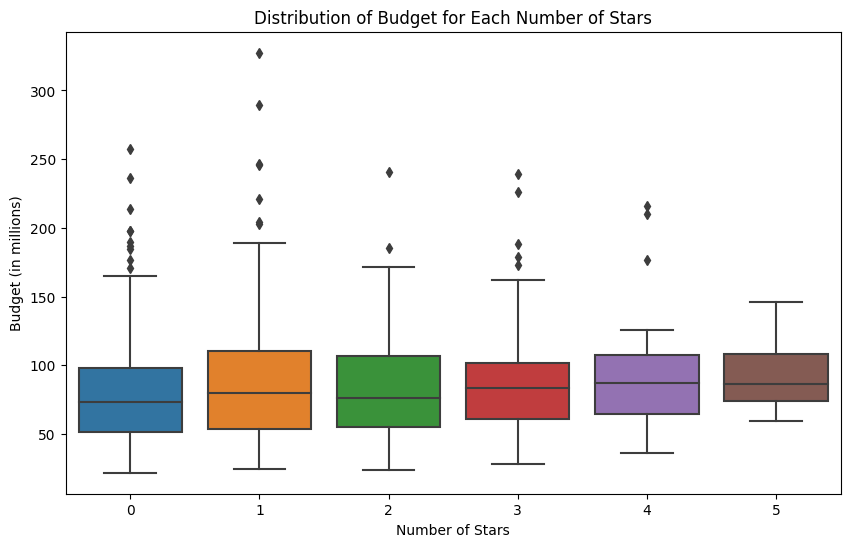

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stars', y='Budget', data=df)
plt.title('Distribution of Budget for Each Number of Stars')
plt.xlabel('Number of Stars')
plt.ylabel('Budget (in millions)')
plt.show()

graph showing the average movie budget over time.

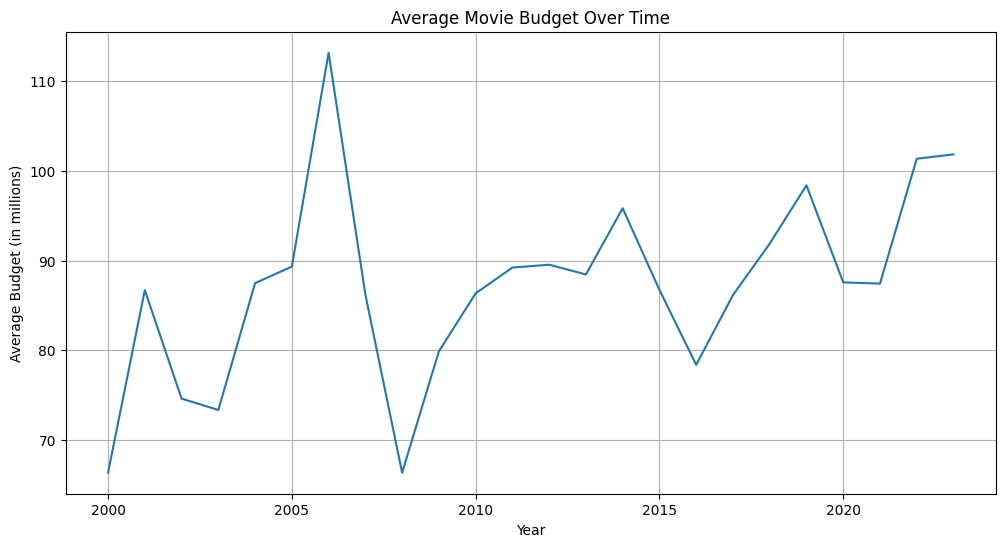

In [39]:
import matplotlib.pyplot as plt
average_budget_per_year = df.groupby('Year')['Budget'].mean()
plt.figure(figsize=(12, 6))
average_budget_per_year.plot(kind='line')
plt.title('Average Movie Budget Over Time')
plt.xlabel('Year')
plt.ylabel('Average Budget (in millions)')
plt.grid(True)
plt.show()

In [40]:
from textblob import TextBlob

# sentiment score calculation
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

for i in range(1, 4):
    df[f'R{i}_Sentiment'] = df[f'R{i}'].apply(get_sentiment)

# Average sentiment score
df['Average_Sentiment'] = df[[f'R{i}_Sentiment' for i in range(1, 4)]].mean(axis=1)

# Budget to Promo Ratio
df['Budget_Promo_Ratio'] = df['Budget'] / df['Promo']

# One-hot encode 'Season'
season_dummies = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, season_dummies], axis=1)

print(df.iloc[0])

Unnamed: 0                                 0
Title                    "Love in the Inbox"
Runtime                                  126
Stars                                      1
Year                                    2020
                                ...         
Genre_Science fiction                      0
Season_Fall                                0
Season_Spring                              0
Season_Summer                              0
Season_Winter                              1
Name: 0, Length: 82, dtype: object


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from textblob import TextBlob


# One-hot encode 'Rating', 'Season', 'Genre'
rating_dummies = pd.get_dummies(df['Rating'], prefix='Rating')
season_dummies = pd.get_dummies(df['Season'], prefix='Season')
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')

df = pd.concat([df, rating_dummies, season_dummies, genre_dummies], axis=1)

# Prepare the data drop non-numeric, target, and original pre one hot encode cols
X = df.drop(['Success', 'Title', 'R1', 'R2', 'R3', 'Season', 'Rating', 'Genre'], axis=1)
y = df['Success'].astype('int')  # Convert 'Success' to integer (0 for FALSE, 1 for TRUE)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Evaluation Metrics:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        91
           1       0.80      0.47      0.59        17

    accuracy                           0.90       108
   macro avg       0.85      0.72      0.77       108
weighted avg       0.89      0.90      0.89       108

Confusion Matrix:
[[89  2]
 [ 9  8]]


# Testing

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from textblob import TextBlob

#prep
X = df.drop(['Success', 'Title', 'R1', 'R2', 'R3', 'Season', 'Rating', 'Genre'], axis=1)
y = df['Success'].astype('int')

# Shuffle and split the data into a 90% training set and a 10% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

# Create and train
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate acc
accuracy = accuracy_score(y_test, y_pred)
print(f"Model's accuracy on the test set: {accuracy:.2f}")

Model's accuracy on the test set: 0.87


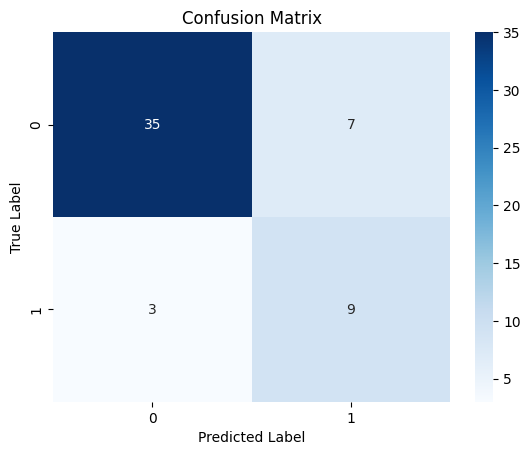

False Positive Rate: 0.17
False Negative Rate: 0.25


In [43]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test)[:, 1]

# decision threshold
threshold = 0.3
y_pred = (y_scores > threshold).astype(int)

# confusion matrix and rates
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
false_positive_rate = FP / (FP + TN)
false_negative_rate = FN / (FN + TP)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")



In [44]:
feature_names = X.columns
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by the absolute value of their coefficients
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
#most important feature
most_important_feature = feature_importance.iloc[0]['Feature']
print(f"Most important feature: {most_important_feature}")
# the sorted feature importance
print(feature_importance)



Most important feature: R1_Sentiment
               Feature  Coefficient  Absolute Coefficient
6         R1_Sentiment     3.232872              3.232872
15   Average_Sentiment     1.228026              1.228026
16  Budget_Promo_Ratio    -0.519037              0.519037
2                Stars     0.494210              0.494210
7         R2_Sentiment     0.487665              0.487665
..                 ...          ...                   ...
63       Season_Summer     0.005012              0.005012
0           Unnamed: 0     0.000678              0.000678
13              year_y    -0.000183              0.000183
9               year_x    -0.000183              0.000183
3                 Year    -0.000183              0.000183

[86 rows x 3 columns]
